# Automated Machine Learning

The flaml library from Microsoft can automate the process of selecting a model and appropriate hyperparameters. 

It is just one of the automated machine learning libraries out there!

First, let's import the flaml library, along with our standard imports for data manipulation and machine learning. 

In [4]:
try:
    from flaml import AutoML
except ModuleNotFoundError:
    !pip install flaml

import pandas as pd
import numpy as np

# Machine learning setup imports
from sklearn.model_selection import train_test_split

# Model imports
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model scoring imports
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, \
                            recall_score, roc_auc_score

We're going to work with the preprocessed titanic data, splitting it into training, validation and testing datasets.

In [5]:
try:
    data = pd.read_csv("data/processed_data.csv")

except FileNotFoundError:
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

data = data.astype(float)

# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

feature_names = X.columns.tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training Dataset Samples: {len(X_train)}")
print(f"Validation Dataset Samples: {len(X_validate)}")
print(f"Testing Dataset Samples: {len(X_test)}")

Training Dataset Samples: 569
Validation Dataset Samples: 143
Testing Dataset Samples: 179


## Simple initial auto ML training

Let's try out a simple instance of automated training with flaml. 

We need to pass in training and testing data, tell it what kind of task we're conducting (e.g. classification, regression), how long to keep trying different models (here, we've gone for 60 seconds), and set a random seed for reproducibility. 

In [6]:
automl = AutoML()
automl.fit(X_train, y_train,
           task="classification",
           time_budget=60,
           seed=42)

[flaml.automl.logger: 07-29 22:31:47] {1680} INFO - task = classification
[flaml.automl.logger: 07-29 22:31:47] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-29 22:31:47] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-29 22:31:47] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-29 22:31:47] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-29 22:31:47] {2345} INFO - Estimated sufficient time budget=603s. Estimated necessary time budget=15s.
[flaml.automl.logger: 07-29 22:31:47] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.1860,	best estimator lgbm's best error=0.1860
[flaml.automl.logger: 07-29 22:31:47] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-29 22:31:47] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.1614,	best estimator lgbm's best error=0.1614
[flaml.automl.logger: 07

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 22:32:47] {2392} INFO -  at 60.0s,	estimator lrl1's best error=0.2926,	best estimator catboost's best error=0.1263


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 22:32:47] {2628} INFO - retrain catboost for 0.4s
[flaml.automl.logger: 07-29 22:32:47] {2631} INFO - retrained model: <catboost.core.CatBoostClassifier object at 0x0000028D49320210>
[flaml.automl.logger: 07-29 22:32:47] {1931} INFO - fit succeeded
[flaml.automl.logger: 07-29 22:32:47] {1932} INFO - Time taken to find the best model: 39.43658995628357


We can run this line to see what model it selected.

In [7]:
automl.model

And this will give us the parameters it chose. 

In [8]:
automl.best_config

{'early_stopping_rounds': 10,
 'learning_rate': 0.08181308076296119,
 'n_estimators': 21}

Finally, we can output the best configuration for each of the estimators it tried. 

In [9]:
automl.best_config_per_estimator

{'lgbm': {'n_estimators': 5,
  'num_leaves': 35,
  'min_child_samples': 12,
  'learning_rate': 0.6152167721646307,
  'log_max_bin': 9,
  'colsample_bytree': 0.9236754665076755,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 2.5956586580400387},
 'rf': {'n_estimators': 4,
  'max_features': 0.31723907926323486,
  'max_leaves': 7,
  'criterion': 'entropy'},
 'catboost': {'early_stopping_rounds': 10,
  'learning_rate': 0.08181308076296119,
  'n_estimators': 21},
 'xgboost': {'n_estimators': 25,
  'max_leaves': 6,
  'min_child_weight': 1.721900224541316,
  'learning_rate': 0.13612393122739494,
  'subsample': 0.8852547114677147,
  'colsample_bylevel': 1.0,
  'colsample_bytree': 0.9877878456495247,
  'reg_alpha': 0.05356904123689876,
  'reg_lambda': 0.007892182790266837},
 'extra_tree': {'n_estimators': 9,
  'max_features': 0.22044476282623449,
  'max_leaves': 6,
  'criterion': 'gini'},
 'xgb_limitdepth': {'n_estimators': 9,
  'max_depth': 7,
  'min_child_weight': 1.5981523613778321,
  'learnin

Now let's evaluate this model and put the results into a dataframe.

We can use our `automl` variable where we'd usually use `model`. 

In [10]:
y_pred_train = automl.predict(X_train)
y_pred_val = automl.predict(X_validate)

tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

results_df = pd.DataFrame({
          'Accuracy (training)': np.mean(y_pred_train == y_train),
          'Accuracy (validation)': np.mean(y_pred_val == y_validate),
          'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
          'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
          "AUC": roc_auc_score(y_validate, y_pred_val),
          "f1": f1_score(y_validate, y_pred_val, average='macro'),
          "FP": fp,
          "FN": fn

          }, index=["Auto ML - Default Parameters - Scoring on ROC AUC"]
).round(3)

results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Auto ML - Default Parameters - Scoring on ROC AUC,0.863,0.811,0.802,0.8,0.8,0.801,13,14


This seems like pretty reasonable performance, based on our previous interactions with the titanic dataset, though not as good as we've seen sometimes.

## Customisation

Let's define a function that will allow us to quickly calculate and store metrics when assessing the `automl` library.

In [11]:
def auto_ml_get_results(name):
    y_pred_train = automl.predict(X_train)
    y_pred_val = automl.predict(X_validate)

    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

    return pd.DataFrame({
            'Accuracy (training)': np.mean(y_pred_train == y_train),
            'Accuracy (validation)': np.mean(y_pred_val == y_validate),
            'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
            'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
            "AUC": roc_auc_score(y_validate, y_pred_val),
            "f1": f1_score(y_validate, y_pred_val, average='macro'),
            "FP": fp,
            "FN": fn

            }, index=[name]
    ).round(3)


Now let's  try training again, this time asking it to score on a different metric - the f1 score.

In [12]:
automl = AutoML()
automl.fit(X_train, y_train,
           task="classification",
           time_budget=60,
           metric="f1",
           seed=42)
results_df = pd.concat(
    [results_df,
    auto_ml_get_results(name="Auto ML - Scoring on f1")]
)

[flaml.automl.logger: 07-29 22:32:47] {1680} INFO - task = classification
[flaml.automl.logger: 07-29 22:32:47] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-29 22:32:47] {1789} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 07-29 22:32:47] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-29 22:32:47] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-29 22:32:49] {2345} INFO - Estimated sufficient time budget=18038s. Estimated necessary time budget=443s.
[flaml.automl.logger: 07-29 22:32:49] {2392} INFO -  at 1.9s,	estimator lgbm's best error=0.4095,	best estimator lgbm's best error=0.4095
[flaml.automl.logger: 07-29 22:32:49] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-29 22:32:49] {2392} INFO -  at 2.0s,	estimator lgbm's best error=0.4095,	best estimator lgbm's best error=0.4095
[flaml.automl.logger: 07-2

## Extending the time 

When we ran it with the default settings previously (our first run), the fifth line of the output gave us the estimated time required to find an optimal model. 

> [flaml.automl.logger: 07-29 12:25:03] {2345} INFO - Estimated sufficient time budget=658s. Estimated necessary time budget=16s.

Let's allocate this length of time.

In [13]:
automl = AutoML()

automl.fit(X_train, y_train,
           task="classification",
           time_budget=658,
           seed=42)

results_df = pd.concat(
    [results_df,
    auto_ml_get_results(name="Auto ML - scoring on ROC AUC - Training for ~11 minutes")]
)

[flaml.automl.logger: 07-29 22:33:49] {1680} INFO - task = classification
[flaml.automl.logger: 07-29 22:33:49] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-29 22:33:49] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-29 22:33:49] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-29 22:33:49] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-29 22:33:53] {2345} INFO - Estimated sufficient time budget=35607s. Estimated necessary time budget=874s.
[flaml.automl.logger: 07-29 22:33:53] {2392} INFO -  at 3.8s,	estimator lgbm's best error=0.1860,	best estimator lgbm's best error=0.1860
[flaml.automl.logger: 07-29 22:33:53] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-29 22:33:54] {2392} INFO -  at 5.1s,	estimator lgbm's best error=0.1614,	best estimator lgbm's best error=0.1614
[flaml.automl.logger:

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 22:44:47] {2631} INFO - retrained model: RandomForestClassifier(max_features=0.35169500377983676, max_leaf_nodes=15,
                       n_estimators=19, n_jobs=-1, random_state=12032022)
[flaml.automl.logger: 07-29 22:44:47] {1931} INFO - fit succeeded
[flaml.automl.logger: 07-29 22:44:47] {1932} INFO - Time taken to find the best model: 281.277902841568


Let's view our updated results table.

In [14]:
results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Auto ML - Default Parameters - Scoring on ROC AUC,0.863,0.811,0.802,0.800,0.800,0.801,13,14
Auto ML - Scoring on f1,0.851,0.804,0.795,0.795,0.795,0.795,14,14
Auto ML - scoring on ROC AUC - Training for ~11 minutes,0.884,0.797,0.787,0.792,0.792,0.789,16,13


## Compare this with some other ML models

Let's define a function to fit and train any provided model, then return the required metrics to be added onto our table from above.

This will allow us to compare the performance of flaml with specifying the model ourselves.

In [15]:
def fit_train(name="XGBoost", X_train=X_train, X_validate=X_validate,
              y_train=y_train, y_validate=y_validate,
              model=XGBClassifier(random_state=42)
              ):

     model.fit(X_train, y_train)

     y_pred_train = model.predict(X_train)
     y_pred_val = model.predict(X_validate)

     tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

     return pd.DataFrame({
            'Accuracy (training)': np.mean(y_pred_train == y_train),
            'Accuracy (validation)': np.mean(y_pred_val == y_validate),
            'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
            'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
            "AUC": roc_auc_score(y_validate, y_pred_val),
            "f1": f1_score(y_validate, y_pred_val, average='macro'),
            "FP": fp,
            "FN": fn
          }, index=[name]
).round(3)

Let's use this to quickly assess the performance of a range of other models.

In [16]:
results_df = pd.concat(
    [results_df,
     fit_train(), # This uses the default - xgboost
     fit_train(name="Decision Tree (Defaults)", model=DecisionTreeClassifier()),
     fit_train(name="Random Forest (Defaults)", model=RandomForestClassifier(random_state=42)),
     fit_train(name="LightGBM (Defaults)", model=LGBMClassifier(random_state=42)),
     fit_train(name="Catboost (Defaults)", model=CatBoostClassifier(random_state=42, verbose=False)),

     ]
)

results_df

[LightGBM] [Info] Number of positive: 212, number of negative: 357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372583 -> initscore=-0.521150
[LightGBM] [Info] Start training from score -0.521150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
Auto ML - Default Parameters - Scoring on ROC AUC,0.863,0.811,0.802,0.800,0.800,0.801,13,14
Auto ML - Scoring on f1,0.851,0.804,0.795,0.795,0.795,0.795,14,14
Auto ML - scoring on ROC AUC - Training for ~11 minutes,0.884,0.797,0.787,0.792,0.792,0.789,16,13
XGBoost,0.979,0.797,0.788,0.786,0.786,0.787,14,15
Decision Tree (Defaults),0.988,0.790,0.780,0.783,0.783,0.781,16,14
Random Forest (Defaults),0.988,0.762,0.751,0.757,0.757,0.753,19,15
LightGBM (Defaults),0.961,0.818,0.810,0.806,0.806,0.808,12,14
Catboost (Defaults),0.923,0.818,0.810,0.806,0.806,0.808,12,14


Let's sort this by validation accuracy. 

In [17]:
results_df.sort_values("Accuracy (validation)", ascending=False)

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN
LightGBM (Defaults),0.961,0.818,0.810,0.806,0.806,0.808,12,14
Catboost (Defaults),0.923,0.818,0.810,0.806,0.806,0.808,12,14
Auto ML - Default Parameters - Scoring on ROC AUC,0.863,0.811,0.802,0.800,0.800,0.801,13,14
Auto ML - Scoring on f1,0.851,0.804,0.795,0.795,0.795,0.795,14,14
Auto ML - scoring on ROC AUC - Training for ~11 minutes,0.884,0.797,0.787,0.792,0.792,0.789,16,13
XGBoost,0.979,0.797,0.788,0.786,0.786,0.787,14,15
Decision Tree (Defaults),0.988,0.790,0.780,0.783,0.783,0.781,16,14
Random Forest (Defaults),0.988,0.762,0.751,0.757,0.757,0.753,19,15


### Ranking model performance

Let's look at another way to quickly compare the performance of the different models.

We will rank each model by its performance against the other models, with a lower number indicating better performance relative to the other models (e.g. the model with the highest precision will be ranked 1; the model with the lowest number of false negatives will be ranked 1).

We will omit training accuracy from our calculations as we are more interested in its likely 'real-world' performance on unseen data.

In [18]:
ranking_df_high_good = results_df[['Accuracy (validation)', 'Precision (validation)', 'Recall (validation)', 'AUC', 'f1']].rank(method='dense', ascending=False).convert_dtypes()
ranking_df_low_good = results_df[['FP', 'FN']].rank(method='dense', ascending=True).convert_dtypes()

ranking_df = ranking_df_high_good.merge(ranking_df_low_good, left_index=True, right_index=True)

ranking_df['Rank Sum'] = ranking_df.sum(axis=1)
ranking_df = ranking_df.sort_values('Rank Sum', ascending=True).convert_dtypes()
ranking_df

,Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN,Rank Sum
LightGBM (Defaults),1,1,1,1,1,1,2,8
Catboost (Defaults),1,1,1,1,1,1,2,8
Auto ML - Default Parameters - Scoring on ROC AUC,2,2,2,2,2,2,2,14
Auto ML - Scoring on f1,3,3,3,3,3,3,2,20
Auto ML - scoring on ROC AUC - Training for ~11 minutes,4,5,4,4,4,4,1,26
XGBoost,4,4,5,5,5,3,3,29
Decision Tree (Defaults),5,6,6,6,6,4,2,35
Random Forest (Defaults),6,7,7,7,7,5,3,42


We could plot this output as well as everything is on the same scale (though we will omit the rank sum) as that's much larger.

<Axes: title={'center': 'Performance Ranking (Higher Rank Value = Worse)'}, xlabel='Rank of Performance'>

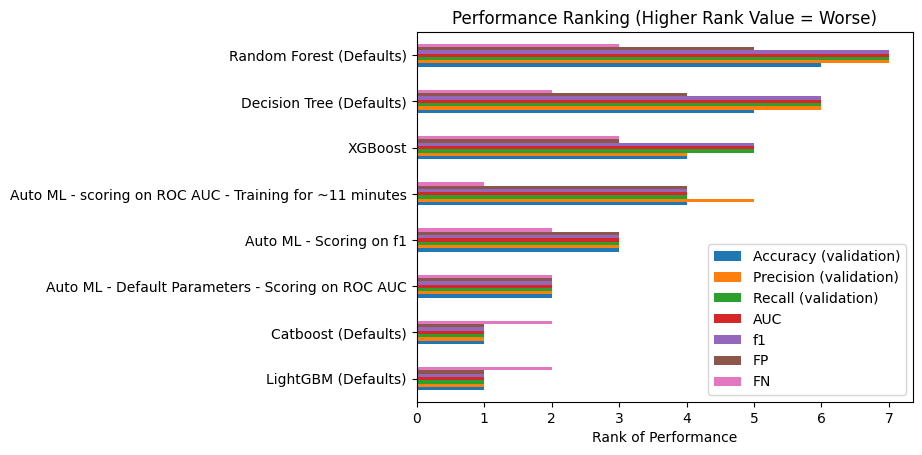

In [19]:
ranking_df.drop(columns="Rank Sum").plot(
    kind="barh",
    title="Performance Ranking (Higher Rank Value = Worse)",
    xlabel="Rank of Performance"
    )